# Regression with ParmEst

In [7]:
import sys
# If running on Google Colab, install Pyomo and Ipopt via IDAES
on_colab = "google.colab" in sys.modules
if on_colab:
    !wget "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/notebooks/tclab_pyomo.py"

# import TCLab model, simulation, and data analysis functions
from tclab_pyomo import TCLabExperiment, create_model, extract_results, extract_plot_results, results_summary

# set default number of states in the TCLab model
number_tclab_states = 2

## Load and explore experimental data

In [8]:
import pandas as pd
if on_colab:
    file = "https://raw.githubusercontent.com/dowlinglab/pyomo-doe/main/data/tclab_sine_test.csv"
else:
    file = '../data/tclab_sine_test.csv'
df = pd.read_csv(file)
df.head()

,Time,T1,T2,Q1,Q2
0,0.00,24.45,24.13,50.0,0.0
1,1.00,24.45,24.13,55.0,0.0
2,2.01,24.45,24.13,60.0,0.0
3,3.01,24.45,24.13,65.0,0.0
4,4.01,24.77,23.81,70.0,0.0


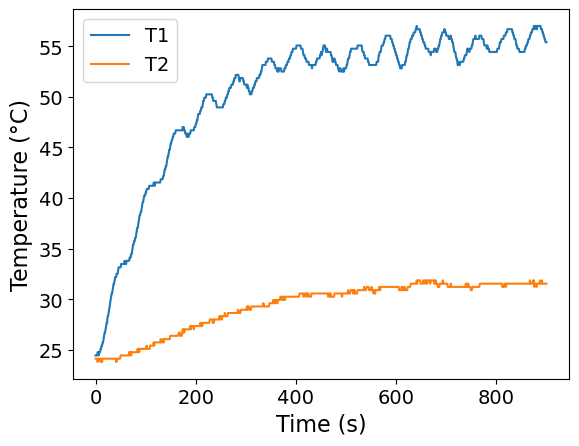

In [9]:
ax = df.plot(x='Time', y=['T1', 'T2'], xlabel='Time (s)', ylabel='Temperature (°C)')

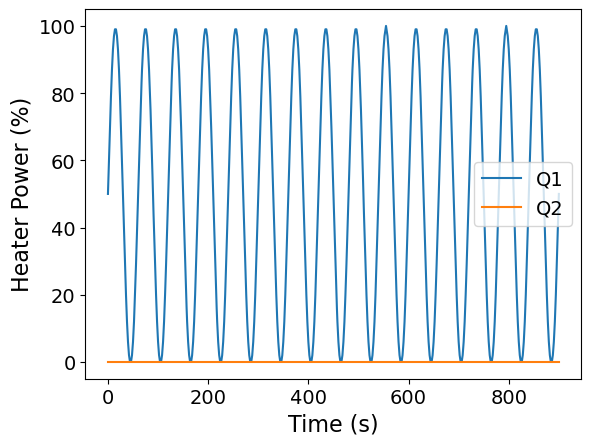

In [10]:
ax = df.plot(x='Time', y=['Q1', 'Q2'], xlabel='Time (s)', ylabel='Heater Power (%)')

## Store in Custom Data Class 

In the file `tclab_pyomo.py`, we defined a `dataclass` for convience. It is essentially a light weight container to store experimental data.

In [11]:
tc_data = TCLabExperiment(name="Sine Wave Test for Heater 1",
                            time=df['Time'].values,
                            T1=df['T1'].values,
                            u1=df['Q1'].values,
                            P1=200,
                            TS1_data=None,
                            T2=df['T2'].values,
                            u2=df['Q2'].values,
                            P2=200,
                            TS2_data=None,
                            Tamb=df['T1'].values[0])

In [12]:
tc_data.to_data_frame().head()

,time,T1,u1,P1,TS1_data,T2,u2,P2,TS2_data,Tamb
0,0.00,24.45,50.0,200,None,24.13,0.0,200,None,24.45
1,1.00,24.45,55.0,200,None,24.13,0.0,200,None,24.45
2,2.01,24.45,60.0,200,None,24.13,0.0,200,None,24.45
3,3.01,24.45,65.0,200,None,24.13,0.0,200,None,24.45
4,4.01,24.77,70.0,200,None,23.81,0.0,200,None,24.45


## Parameter Estimation with ParmEst

In the `tclab_pyomo.py` model, we defined several helper functions:
* `create_model` generates a Pyomo model that is initialized using a numeric integrator. The `mode` option determines which objective function to include.
* `extract_results` takes a Pyomo model and returns the results stored in an instance of the `TCLabExperiment` dataclass.
* `extract_plot_results` takes experimental data (stored in a `TCLabExperiment` instance) and a Pyomo model. The function then generates plots showing the data and model predictions.
* `results_summary` summarizes the Pyomo.DoE results. We'll use this later in the workshop.

`parmest` assumes the regression objective is specified in a specific way. Here is a code exercpt from `tclab_pyomo.py`:

```
m.FirstStageCost = Expression(expr=0)
m.SecondStageCost = Expression(expr=sum((m.Ts1[t] - m.Ts1_measure[t])**2 
    + obj_weight_estimate*(m.Th1[t] - m.Ts1_measure[t])**2 for t in m.t))
m.Total_Cost_Objective = Objective(expr=m.FirstStageCost 
    + m.SecondStageCost, sense=minimize)
```

In [ ]:
import pyomo.contrib.parmest.parmest as parmest

# define the parameter names as a list
if number_tclab_states == 2:
    theta_names = ['Ua', 'Ub', 'inv_CpH', 'inv_CpS']
else:
    theta_names = ['Ua', 'Ub', 'Uc','inv_CpH', 'inv_CpS']

parmest_create_model = lambda data: create_model(data=data, 
                                                 mode='parmest', 
                                                 number_of_states=number_tclab_states)

# Create a parameter estimation object
pest = parmest.Estimator(parmest_create_model,
                         data=[tc_data.to_data_frame()], # Needs to be a list of dataframes, otherwise parmest threats each row as a separate model
                         theta_names=theta_names,
                         tee=True)

obj, theta = pest.theta_est()

Ipopt 3.13.2: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-scale scientific
        computation. See http://

During Summer 2024, we are creating a new modeling interface for `parmest` and `Pyomo.DoE`. This notebook currently uses the legacy `parmest` interface, hence the depreciation warnings above. Once the revisions are complete, we will update this workshop website.

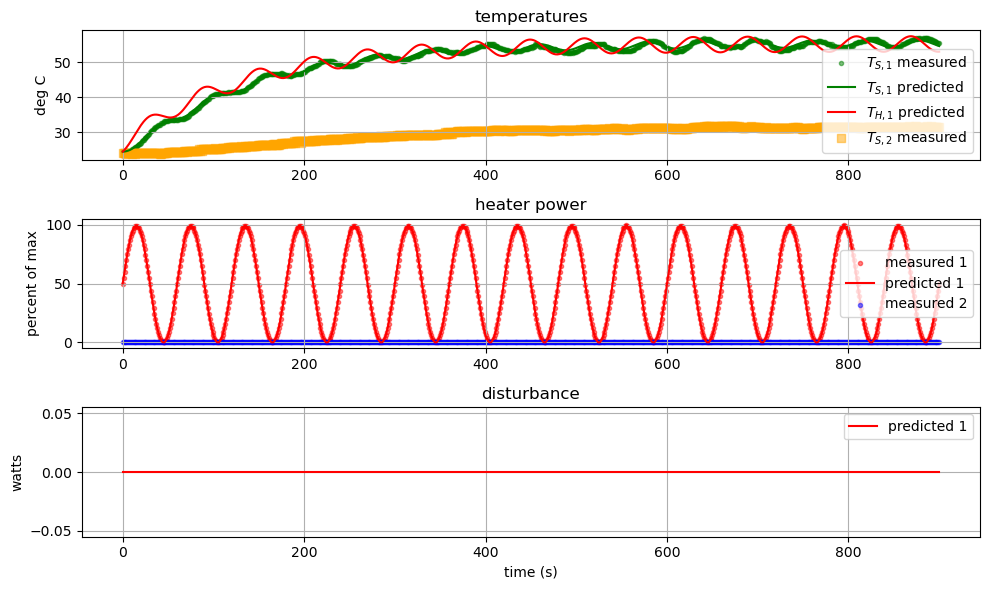

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [ ]:
parmest_regression_results = extract_plot_results(tc_data, pest.pest_deprecated.parmest_model)

Let's see how to access the regression results:

In [ ]:
theta_values = theta.to_dict()
print("Estimated parameters:\n",theta_values)

Estimated parameters:
 {'Ua': 0.05147278733764144, 'Ub': 0.0005342082803591553, 'inv_CpH': 0.14622879403174288, 'inv_CpS': 99.99999854623738}


## Covariance Matrix

In [ ]:
# Estimate the covariance matrix
obj, theta, cov = pest.theta_est(calc_cov=True, # boolean to calculate the covariance matrix
                                                  cov_n = len(tc_data.time) # number of data points in the least squares objective
                                                  )

Ipopt 3.13.2: bound_relax_factor=0
honor_original_bounds=no


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt

This version of Ipopt was compiled from source code available at
    https://github.com/IDAES/Ipopt as part of the Institute for the Design of
    Advanced Energy Systems Process Systems Engineering Framework (IDAES PSE
    Framework) Copyright (c) 2018-2019. See https://github.com/IDAES/idaes-pse.

This version of Ipopt was compiled using HSL, a collection of Fortran codes
    for large-scale scientific computation.  All technical papers, sales and
    publicity material resulting from use of the HSL codes within IPOPT must
    contain the following acknowledgement:
        HSL, a collection of Fortran codes for large-sca

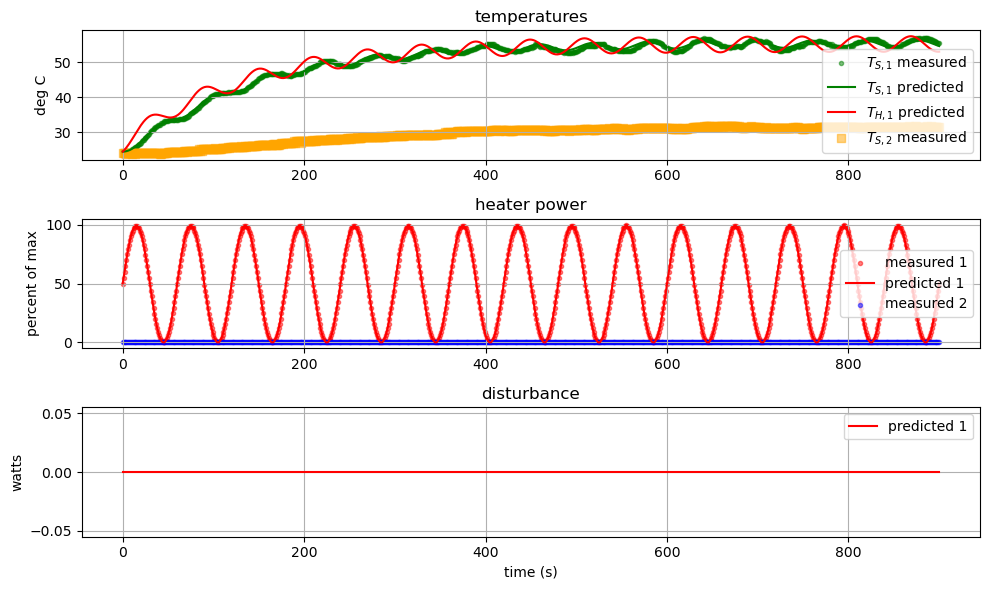

Model parameters:
Ua = 0.0515 Watts/degC
Ub = 0.0005 Watts/degC
CpH = 6.8386 Joules/degC
CpS = 0.01 Joules/degC
 


In [ ]:
parmest_regression_results2 = extract_plot_results(tc_data, pest.pest_deprecated.parmest_model)

In [ ]:
print(cov)

                   Ua            Ub       inv_CpH       inv_CpS
Ua       2.205182e-09 -2.420538e-10  2.275436e-08  7.737639e-13
Ub      -2.420538e-10  2.073777e-10 -1.036322e-08  6.894656e-09
inv_CpH  2.275436e-08 -1.036322e-08  7.628117e-07  3.246808e-09
inv_CpS  7.737639e-13  6.894656e-09  3.246808e-09 -1.292939e-03
